# Model Predictive Control

Given a discrete-time control problem with a horizon $\tau$ that is potentially very large, the model predictive control approach consists of 
1. solving the problem on a small window of $w$ time steps such that we get a sequence of controller $u_{0:w}^*$,
2. moving the window by $t$ time steps with $t\leq w$; the goal is then to find a sequence of controls $u_{t:t+w}$,
3. solving the problem on the newly defined window, where 
    1. the initial state is now $x_t^*$, the state corresponding to $t$ steps of the optimal sequence of controllers $u_{0:w}^*$,
    2. the new problem is initialized as $u_{t:t+w}^{(0)}$ such that $ u_{t:w}^{(0)} = u_{t:w}^*$, i.e., we keep the previously computed solution on the overlapping time steps; the rest of the initial controls can either be chosen to be 0 or to be chosen as the last control $u_w^*$ repeated until $t+w$, i.e.,  $u_{w:w+t}^{(0)} = \underbrace{(u^*_w, \ldots, u_w^*)}_{\text{t times}}$,
4. repeating the procedure until the whole horizon $\tau$ has been covered.

<center><img src="fig/mpc_illus.png" alt="Model Predictive Control" width="350" /></center>

   
In the following code, we directly use the primitives present in the package. The code below implements a simple step of model predictive control, i.e., finding the optimal sequence of controllers on some windows. 

In [1]:
from copy import deepcopy
import torch
import time
from matplotlib import pyplot as plt

torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
from copy import deepcopy
import os
import torch

from algorithms.run_min_algo import run_min_algo, check_cvg_status
from envs.choose_env import make_env
from utils_pipeline.record_exp import run_and_record_exp_wrapper, load_exp


results_folder = 'results'

# In the following env_cfg and optim_cfg are dictionaries of parameters 
# that define respectively the environment considered and the parameters used in the optimization

def mpc_step(env, full_horizon, overlap, max_iter=10, algo='ddp_linquad_reg', optim_on_full_window=False,
             keep_applying_last_ctrl=True, prev_cmd=None):
    # Solve the problem for a large horizon by cutting it in small subproblems that overlap
    curr_horizon = len(prev_cmd) if prev_cmd is not None else 0
    # Compared to the previous solution there is some adiditonal time steps to consider
    additional_time_steps = full_horizon - curr_horizon

    if prev_cmd is not None:
        # Initialize the command from the previous command found (given in the input)
        # As the window moved some new control variables have to be optimized 
        # By default (keep_ctrl=True) these new variables are initialized by the last controllers found before
        if keep_applying_last_ctrl:
            additional_cmd = prev_cmd[-1].repeat(additional_time_steps, 1)
        else:
            additional_cmd = torch.zeros(additional_time_steps, env.dim_ctrl)
        if optim_on_full_window:
            init_cmd = torch.cat((prev_cmd, additional_cmd))
        else:
            init_cmd = torch.cat((prev_cmd[curr_horizon - overlap:], additional_cmd))
            traj, _ = env.forward(prev_cmd)
            env.init_state = traj[curr_horizon - overlap].data
            env.init_time_iter = curr_horizon - overlap

        cmd, _, metrics = run_min_algo(env, max_iter, algo, prev_cmd=init_cmd)
    else:
        cmd, _, metrics = run_min_algo(env, max_iter, algo)

    if prev_cmd is None or optim_on_full_window:
        cmd_opt = cmd.data
    else:
        cmd_opt = torch.cat((prev_cmd[:-overlap], cmd.data))

    return cmd_opt, metrics


def run_mpc_step(env_cfg, optim_cfg, prev_cmd=None):
    # Wrapper used to save/reload similar configurations of environment and optimization
    env = make_env(env_cfg)
    cmd_opt, metrics = mpc_step(env, prev_cmd=prev_cmd, **optim_cfg)
    exp_outputs = dict(cmd_opt=cmd_opt, metrics=metrics)
    return exp_outputs


output_to_input = dict(cmd_opt='prev_cmd')


def check_exp_fail(exp_outputs):
    return check_cvg_status(exp_outputs['metrics'], verbose=False) == 'diverged'


run_and_record_mpc_step = run_and_record_exp_wrapper(run_mpc_step, output_to_input, check_exp_fail,
                                                     'full_horizon', results_folder)


def run_mpc(env_cfg, optim_cfg):
    print('env_cfg: {0} \noptim_cfg: {1}'.format(env_cfg, optim_cfg))
    exp_outputs = load_exp(dict(env_cfg=env_cfg, optim_cfg=optim_cfg), results_folder)
    exp_done = exp_outputs is not None
    if not exp_done:
        horizon = 0
        max_horizon, window_size, overlap = optim_cfg['full_horizon'], optim_cfg['window_size'], optim_cfg['overlap']
        sliding_time = window_size - overlap
        while horizon < max_horizon:
            temp_optim_cfg = deepcopy(optim_cfg)
            horizon = min(max(horizon + sliding_time, window_size), max_horizon)
            del temp_optim_cfg['window_size']
            temp_optim_cfg['full_horizon'] = horizon
            exp_outputs = run_and_record_mpc_step(env_cfg, temp_optim_cfg)
            if check_exp_fail(exp_outputs):
                print('Maximum horizon: {}'.format(horizon))
                break
    cmd_opt = exp_outputs['cmd_opt']
    return cmd_opt

We can then get the whole movement of the car on a track by solving the control problem on small sliding windows as follows.

env_cfg: {'env': 'real_car', 'track': 'complex', 'reg_cont': 1.0, 'reg_lag': 1.0, 'reg_speed': 1.0, 'vref': 2.5} 
optim_cfg: {'algo': 'ddp_linquad_reg', 'max_iter': 10, 'overlap': 39, 'window_size': 40, 'full_horizon': 160}


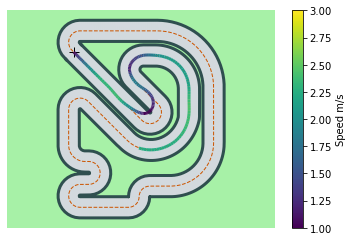

In [3]:
horizon = 160
env_cfg = dict(env='real_car', track='complex',
               reg_cont=1., reg_lag=1., reg_speed=1., vref=2.5)
optim_cfg_mpc = dict(algo='ddp_linquad_reg', max_iter=10, overlap=39, window_size=40, full_horizon=horizon)

cmd_mpc = run_mpc(env_cfg, optim_cfg_mpc)

env = make_env(env_cfg)
traj, costs = env.forward(cmd_mpc)

fig, ax = env.plot_track()
fig = env.plot_traj(traj, fig, ax)
plt.show()

env.visualize(cmd_mpc)

By playing with the parameters of the objective, we can get numerous different trajectories. These trajectories can then be seen as examples that can be learned by, e.g., a deep network, as explained in the notebook [Imitation Learning](imitation.ipynb).